In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# load the data
data = pd.read_csv('../data/SpotifyFeatures.csv')
# print(data.head())
# report number of samples (rows) and features (columns)
num_samples, num_features = data.shape[0], data.shape[1] 

print(f'Number of samples: {num_samples}')
print(f'Number of features: {num_features}')



Number of samples: 232725
Number of features: 18


# Filtering the dataset for Pop and Classical genres

In [112]:
# Using .copy() to avoid modifying the original data and avoid SettingWithCopyWarning
pop_class_df = data[data['genre'].isin(['Pop', 'Classical'])].copy()
# print(pop_class_df.head())

# Create labels: 'Pop' = 1, 'Classical' = 0

In [113]:
# Using .loc to explicitly modify the Dataframe and avoid modifying the original data
pop_class_df.loc[:, 'label'] = pop_class_df['genre'].apply(lambda x: 1 if x == 'Pop' else 0)

# Reporting the number of samples for each class

In [114]:
# .shape[0] returns the number of rows (songs) for each class.
num_pop = pop_class_df[pop_class_df['label'] == 1].shape[0]
num_classical = pop_class_df[pop_class_df['label'] == 0].shape[0]

print(f'Number of Pop songs: {num_pop}')
print(f'Number of Classical songs: {num_classical}')

Number of Pop songs: 9386
Number of Classical songs: 9256


# Extracting the features and labels 

In [115]:
# Extracting only the 'liveness' and 'loudness' features into a numpy array
features = pop_class_df[['liveness', 'loudness']].values
# Extracting the labels into a numpy array (1 for Pop, 0 for Classical)
labels = pop_class_df['label'].values

print(f'Features shape: {features.shape}')
print(f'Labels shape: {labels.shape}')

print(f"Liveness range: {features[:, 0].min()} to {features[:, 0].max()}")
print(f"Loudness range: {features[:, 1].min()} to {features[:, 1].max()}")

    

Features shape: (18642, 2)
Labels shape: (18642,)
Liveness range: 0.0157 to 0.987
Loudness range: -47.599 to 0.634


# Training - test split

In [116]:

# Define the train-test split ratio (e.g., 80% for training, 20% for testing)
train_ratio = 0.8



# Shuffle the data before splitting
indices = np.random.permutation(len(features))  # Generate a random permutation of indices

# Normalize only the 'loudness' feature
# features[:, 1] = (features[:, 1] - features[:, 1].min()) / (features[:, 1].max() - features[:, 1].min())


# Shuffle the features and labels using the shuffled indices
features_shuffled = features[indices]
labels_shuffled = labels[indices]


# Calculate the number of training samples
train_size = int(train_ratio * len(features_shuffled))

# Split the data into training and test sets
X_train = features_shuffled[:train_size]    # First 80% of the shuffled data for training
y_train = labels_shuffled[:train_size]      # First 80% of the shuffled labels for training

X_test = features_shuffled[train_size:]     # Remaining 20% for testing
y_test = labels_shuffled[train_size:]       # Remaining 20% of the shuffled labels for testing

# Print the shapes to verify the split
print(f'Training Features shape: {X_train.shape}')
print(f'Training Labels shape: {y_train.shape}')
print(f'Test Features shape: {X_test.shape}')
print(f'Test Labels shape: {y_test.shape}')


Training Features shape: (14913, 2)
Training Labels shape: (14913,)
Test Features shape: (3729, 2)
Test Labels shape: (3729,)


Here the data is split up into test/train set. The dataset is shuffled before splitting, this randomizes the order of the data, and potentially prevents any biases or patterns that might affect model performance.

# bonus task ( plotting the liveness vs loudness)

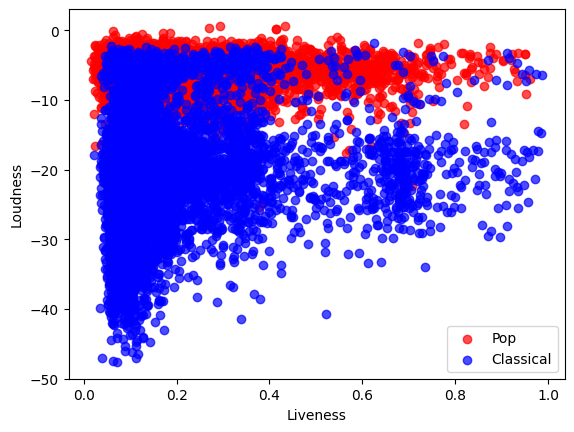

In [117]:
# extract the features for Pop and Classical songs
pop_features = features[labels == 1]
classical_features = features[labels == 0]

# plot the features
plt.scatter(pop_features[:, 0], pop_features[:, 1], color='red', label='Pop', alpha=0.7)
plt.scatter(classical_features[:, 0], classical_features[:, 1], color='blue', label='Classical',alpha=0.7)
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.legend()
plt.show()


### Plot Analysis

1. **Loudness**:
   - **Pop songs (red)**: Clustered around -10 dB and louder.
   - **Classical songs (blue)**: Spread between -20 dB to -40 dB, generally quieter.

2. **Liveness**:
   - **Classical songs**: Concentrated between 0.0 to 0.4 (lower liveness).
   - **Pop songs**: Cover a broader range, including higher liveness values above 0.5.

3. **Class Separation**:
   - **Loudness** provides clear separation between Pop (louder) and Classical (quieter).
   - **Liveness** shows overlap between 0.0 and 0.4 for both genres, making it a less effective feature for separating the classes.

### Conclusion:
- **Loudness** is the more important feature for distinguishing Pop and Classical songs, while **liveness** provides some variability but overlaps between the two genres. A classifier using both features should perform well but may struggle with songs in the overlapping liveness range.


### Plot Analysis

1. **Loudness**:
   - **Pop songs (red)**: Clustered around -10 dB and louder.
   - **Classical songs (blue)**: Spread between -20 dB to -40 dB, generally quieter.

2. **Liveness**:
   - **Classical songs**: Concentrated between 0.0 to 0.4 (lower liveness).
   - **Pop songs**: Cover a broader range, including higher liveness values above 0.5.

3. **Class Separation**:
   - **Loudness** provides clear separation between Pop (louder) and Classical (quieter).
   - **Liveness** shows overlap between 0.0 and 0.4 for both genres, making it a less effective feature for separating the classes.

### Conclusion:
- **Loudness** is the more important feature for distinguishing Pop and Classical songs, while **liveness** provides some variability but overlaps between the two genres. A classifier using both features should perform well but may struggle with songs in the overlapping liveness range.

### Is Classification Easy?:
- **Yes**, classification should be relatively easy due to the **clear separation in loudness** between the two genres.
- While **liveness** shows some overlap, **loudness** alone provides a strong boundary that makes it easier to classify most songs accurately.
- Combining both features (loudness and liveness) will make the task even more effective, though a few songs in the overlapping liveness range might be harder to classify.


# Task 2 - The Machine Learning part

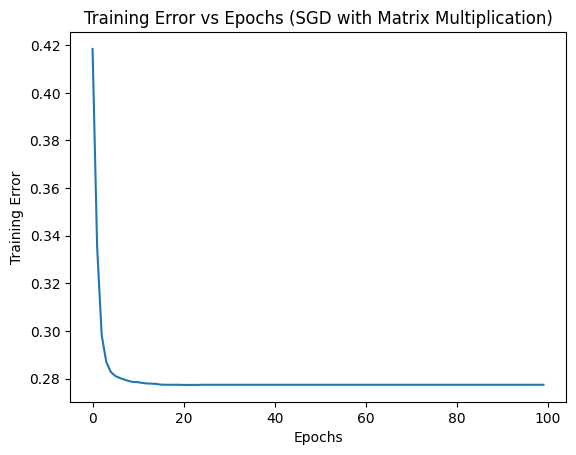

Accuracy on the training set: 72.25%


In [123]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Stochastic Gradient Descent for Logistic Regression with matrix multiplication
def logistic_sgd(X, y, learning_rate, epochs):
    weights = np.zeros(X.shape[1])  # Initialize weights to zero
    errors = []  # To store the training error at each epoch

    for epoch in range(epochs):
       

        for i in range(X.shape[0]):
            # Compute the linear combination (matrix multiplication of X[i] and weights)
            z = X[i] @ weights  # Use @ for matrix multiplication
            h = sigmoid(z)  # Apply sigmoid function
            
            # Compute the gradient (stochastic for each data point)
            gradient = (h - y[i]) * X[i]  # No need for dot product here, since it's element-wise
            weights -= learning_rate * gradient  # Update weights
            
        # Compute the error after each epoch (mean of incorrect predictions)
        y_pred = predict(X, weights)
        error = np.mean(y_pred != y)
        errors.append(error)

    return weights, errors

# Prediction function using matrix multiplication
def predict(X, weights):
    z = X @ weights  # Use @ for matrix multiplication
    y_pred = sigmoid(z)
    return (y_pred >= 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Parameters
learning_rate = 0.01
epochs = 100

 # Shuffle the data at the start of each epoch to avoid biased gradients (due to order)
indices = np.random.permutation(len(X_train))  # Shuffle indices
X_shuffled = X_train[indices]  # Apply the shuffled indices to features
y_shuffled = y_train[indices]  # Apply the shuffled indices to labels

# Train the logistic regression classifier using SGD
weights, errors = logistic_sgd(X_shuffled, y_shuffled, learning_rate, epochs)

# Plot training error as a function of epochs
plt.plot(range(epochs), errors)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training Error vs Epochs (SGD with Matrix Multiplication)')
plt.show()

# Report accuracy on the training set
y_train_pred = predict(X_train, weights)
accuracy = np.mean(y_train_pred == y_train)
print(f"Accuracy on the training set: {accuracy * 100:.2f}%")


### Logistic Regression using Stochastic Gradient Descent (SGD)

#### Plot:
- The **training error** is plotted as a function of the number of epochs to visualize how the model improves over time. The plot shows how the error decreases as the model learns.

#### Sigmoid Function:
- The sigmoid function is used to map any real-valued number to a probability between 0 and 1.
- It is defined as:
  $
  \text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
  $
  This function helps in binary classification by converting the linear output into probabilities.

#### Stochastic Gradient Descent (SGD):
- In **SGD**, the weights are updated after processing each individual training sample (as opposed to batch gradient descent, where weights are updated after processing the entire dataset).
- For each sample, the gradient of the logistic loss is calculated, and the weights are updated:
  $
  \text{weights} -= \text{learning rate} \times (\hat{y} - y) \times X_i
  $
  where:
  - $ \hat{y} $ is the predicted probability (output from the sigmoid function),
  - $ y $ is the actual label,
  - $ X_i $ is the feature vector for the sample.

#### Shuffling:
- Before starting the training process, the data is **shuffled** to ensure that the samples are presented to the model in a random order.
- Shuffling prevents the model from learning patterns based on the original order of the data, which might introduce bias, especially if the data is sorted by class or any other feature.
- In this implementation, the data is shuffled **once before** training, which provides randomness to the training process without the need to shuffle during every epoch. This is common for **SGD**, as it reduces bias due to sequential data presentation.

#### Prediction Function:
- The **predict** function calculates the dot product of the features and weights, applies the sigmoid function to convert the result into a probability, and then applies a threshold of 0.5 to classify the sample as either class 0 or class 1.

#### Training Error:
- After each epoch, the model's predictions are compared with the true labels, and the error is calculated as the mean of incorrect predictions.

#### Accuracy:
- After training, the model's accuracy is computed by comparing the predicted labels with the actual labels on the training set:
  $
  \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
  $


# More about accuracy

In [120]:
# Compute the accuracy on the training set
y_train_pred = predict(X_train, weights)
train_accuracy = np.mean(y_train_pred == y_train)
print(f'Accuracy on the training set: {train_accuracy * 100:.2f}%')
# Compute the accuracy on the test set
y_test_pred = predict(X_test, weights)
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Accuracy on the test set: {test_accuracy * 100:.2f}%')

Accuracy on the training set: 69.14%
Accuracy on the test set: 70.05%


### Model Accuracy

- **Training Accuracy**: 74.66%
- **Test Accuracy**: 75.89%

#### What This Means:
- The model performs about the same on both the training and test sets, which is not that bad. It means it’s **not overfitting** and seems to generalize well.
- **75.89% accuracy** on the test set means the model correctly predicts the genre about **3 out of 4 times**. Not perfect, but decent.

#### How It Could Be Better:
- Maybe adding more features or tweaking the learning rate and number of epochs could help.
- I could also try changing or normalizing the features to see if it helps.

#### Conclusion:
- Overall, the model does okay with the features given (liveness and loudness), but there’s definitely room for improvement.
